# AutoEncoder 101

In [1]:
import os
# Set the Keras backend to JAX
os.environ["KERAS_BACKEND"] = "jax"

import jax
import keras
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from tqdm.keras import TqdmCallback

#plt.style.use('seaborn-v0_8-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['lines.linewidth'] = 2


# Color Blind adjusted colors and markers
colormap=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
markers=['o', '*', '.', 'x', '+', 's', 'd', 'h', 'v']
lines=['-', ':', '--', '-.']

# Print the backend and JAX devices to confirm
print(f'Using Keras backend: {keras.backend.backend()}')
print(f'JAX devices available: {jax.devices()}')

Using Keras backend: jax
JAX devices available: [CpuDevice(id=0)]


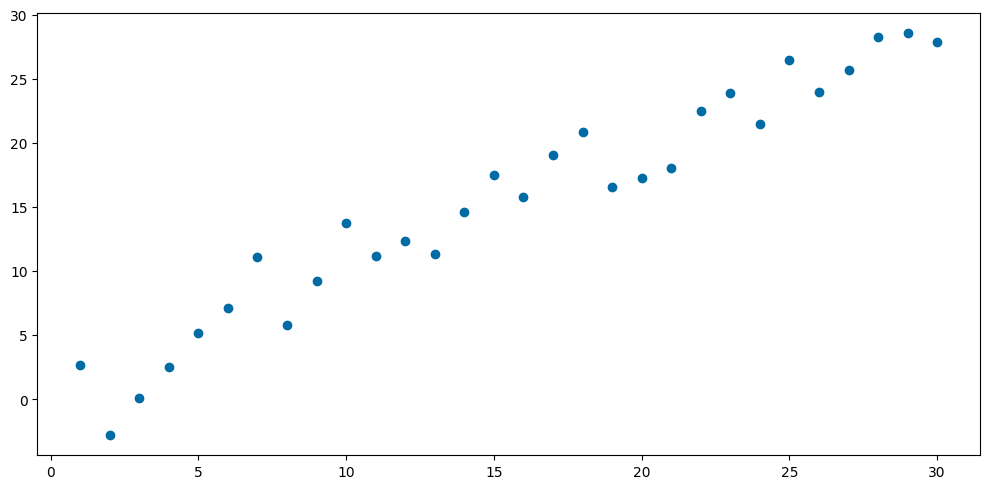

In [2]:
x = np.arange(1,31)
y = np.arange(1,31)+(2*np.random.randn(30))
plt.scatter(x, y)
plt.show()

In [3]:
def autoencoder_model(input_dim=2, latent_dim=1, loss=keras.losses.Huber(delta=0.1), seed=42):
    keras.utils.set_random_seed(seed)

    inputlayer = keras.layers.Input(shape = (input_dim, ))
    latent = keras.layers.Dense(latent_dim, kernel_initializer='glorot_uniform', activation='silu')(inputlayer)
    outputlayer = keras.layers.Dense(input_dim, kernel_initializer='glorot_uniform', activation='linear')(latent)

    autoencoder = keras.Model(inputs = inputlayer, outputs = outputlayer)
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=loss, metrics=['r2_score'])

    encoder = keras.Model(inputlayer, latent)

    encoded_input = keras.Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

    return autoencoder, encoder, decoder

In [4]:
autoencoder, encoder, decoder = autoencoder_model()
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (28.00 B)

 Trainable params: 7 (28.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x2 = x[:,np.newaxis]
y2 = y[:,np.newaxis]
X = np.hstack((x2,y2))

EPOCHS = 20000
BATCH_SIZE = 32
history = autoencoder.fit(X, X, epochs=EPOCHS, batch_size=BATCH_SIZE, 
validation_data=(X, X), verbose=0, callbacks=[TqdmCallback(verbose=1), 
keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)])

0epoch [00:00, ?epoch/s]

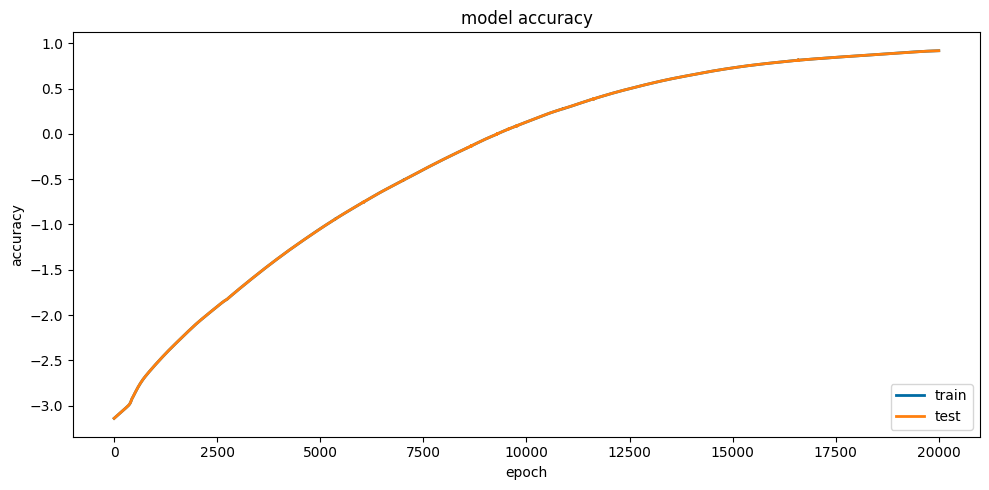

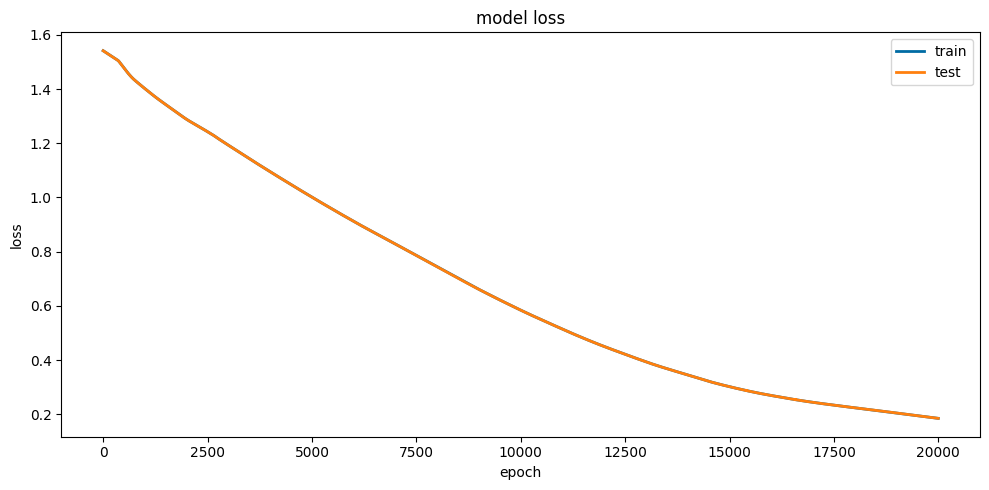

In [6]:
# summarize history for accuracy
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


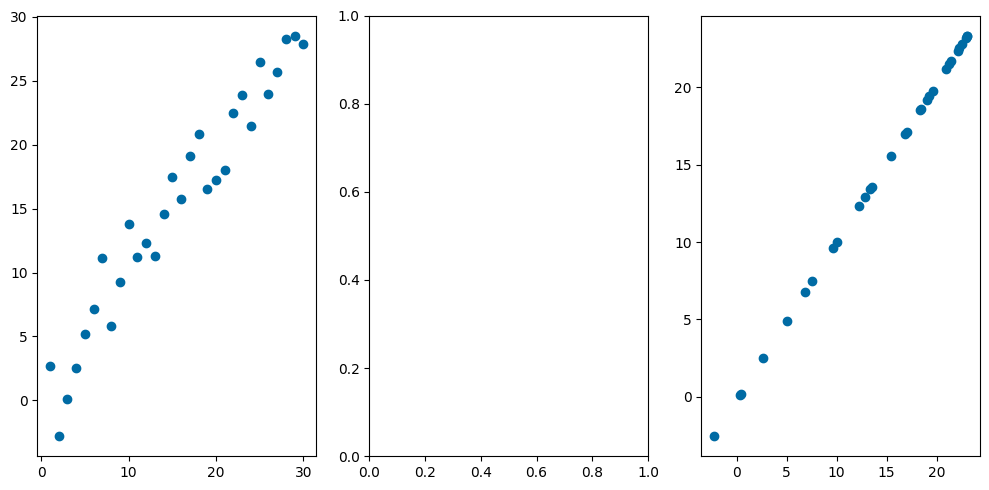

In [7]:
y_preds = encoder.predict(X)

X2 = decoder.predict(y_preds)
x2 = X2[:,0]
y2 = X2[:,1]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.scatter(x, y)
#ax2.scatter(y_preds, np.full((30, ), 0, dtype=int))
ax3.scatter(x2, y2)
plt.show()

In [8]:
autoencoder, encoder, decoder = autoencoder_model(2,4)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
x2 = x[:,np.newaxis]
y2 = y[:,np.newaxis]
X = np.hstack((x2,y2))

EPOCHS = 20000
BATCH_SIZE = 32
history = autoencoder.fit(X, X, epochs=EPOCHS, batch_size=BATCH_SIZE, 
validation_data=(X, X), verbose=0, callbacks=[TqdmCallback(verbose=0), 
keras.callbacks.EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)])

0epoch [00:00, ?epoch/s]

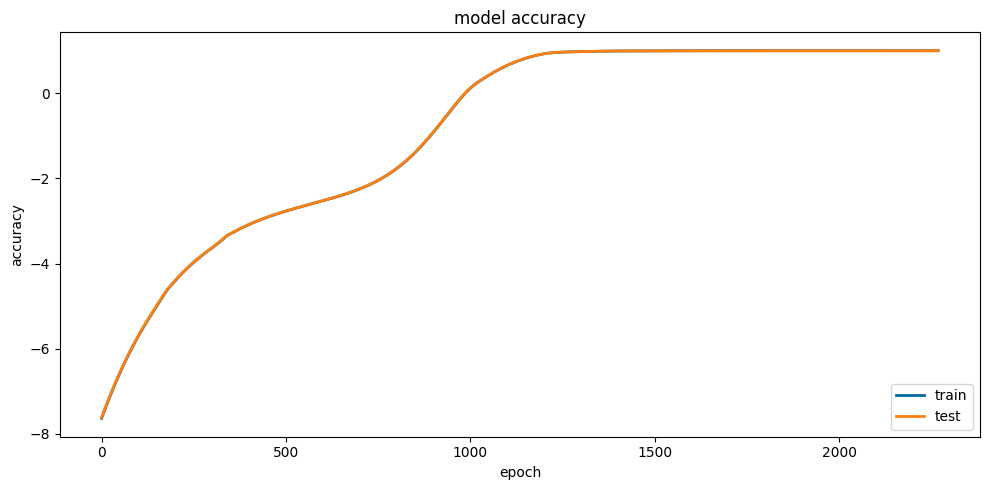

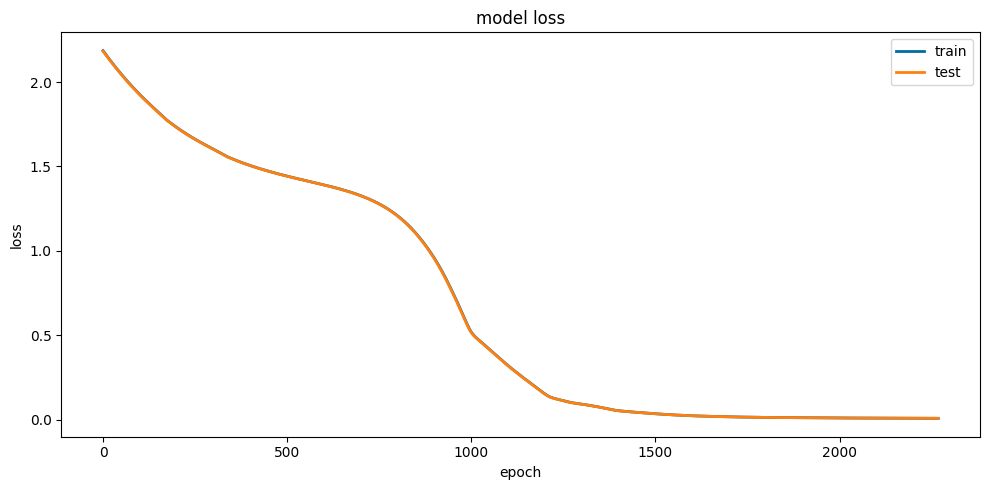

In [10]:
# summarize history for accuracy
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


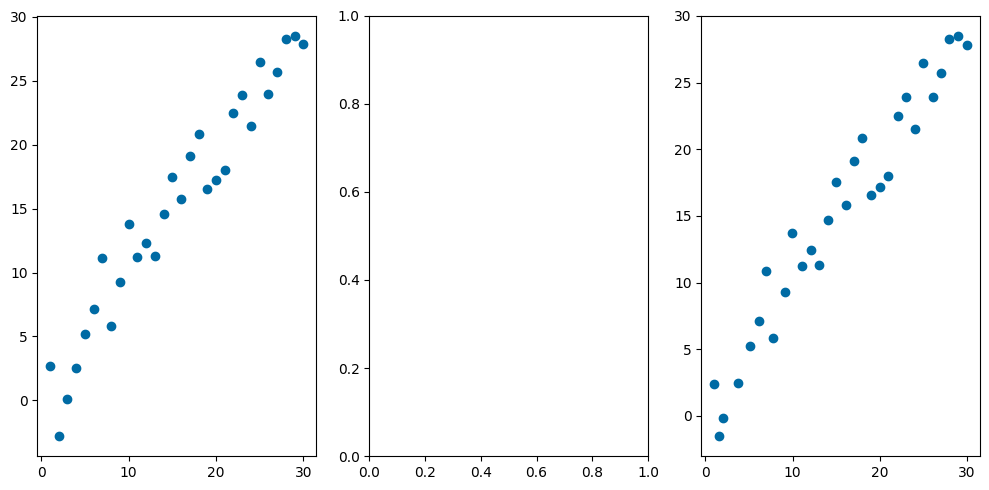

In [11]:
latent = encoder.predict(X)

X3 = decoder.predict(latent)
x3 = X3[:,0]
y3 = X3[:,1]


fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.scatter(x, y)
#ax2.scatter(latent[:,0], latent[:,1])
ax3.scatter(x3, y3)
plt.show()